In [549]:
# import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin,BaseEstimator

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVR, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

# Import data

In [550]:
data = pd.read_csv('C:\\Users\\Admin\\Desktop\\titanic\\train.csv')

# 1. Data overview

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

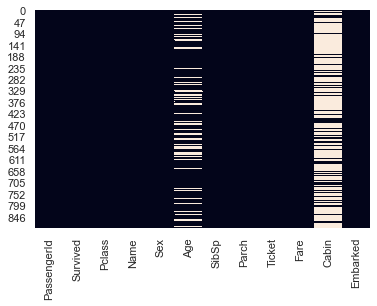

In [551]:
data.info()
sns.heatmap(data.isnull(), cbar=False)
data.isnull().sum()

## Data variable describe
* Survived : survival ( 0 = No, 1 = Yes)
* Pclass: Ticket class ( 1 = 1st, 2 = 2nd, 3 = 3rd)
* Sex : gender
* Age : Age in years
* Sibsp : number of siblings/spouses aboard Titanic
* Parch : number of parents/children aboard Titanic
* Ticket: ticket number
* Fare : passenger fare
* Cabin : cabin number
* Embarked: port of Embarkation

In [552]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [553]:
data.loc[data['Fare'] == 0,'Fare'].count()

15

**Conclustion:**
* **Age, Cabin, Embarked** have missing value.
* Dataset's shape (891,12)
* **Fare** have 15 rows having 0 value, we need to handle these value.
* The missing value have no pattern

# 2. Explorated Data Analysis

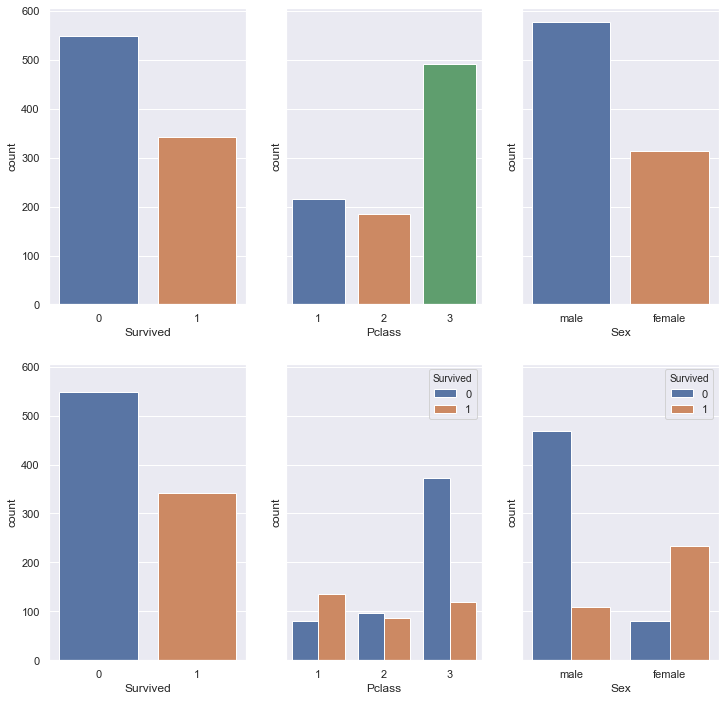

In [554]:
fig , ax = plt.subplots(2,3, figsize = (12,12), sharey=True)
sns.countplot(x='Survived', data=data, ax=ax[0,0])
sns.countplot(x='Pclass', data=data, ax=ax[0,1])
sns.countplot(x='Sex', data=data, ax=ax[0,2])
sns.countplot(x='Survived', data=data, ax=ax[1,0])
sns.countplot(x='Pclass', data=data, hue='Survived', ax=ax[1,1])
sns.countplot(x='Sex', data=data, hue='Survived', ax=ax[1,2])

**Conclusion**
* Class 3 have higher probability of dead than other class.
* Male have higher probability of dead than female

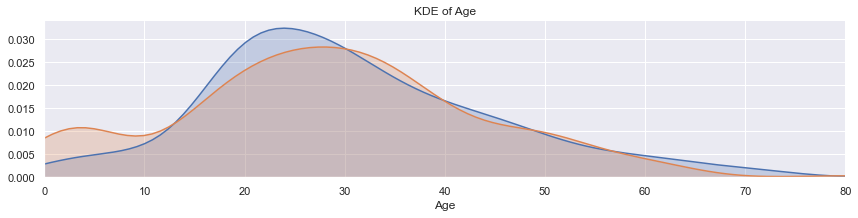

In [555]:
sns.set()
facet = sns.FacetGrid(data=data, hue='Survived', aspect = 4)
facet.map(sns.kdeplot, 'Age', shade=True)
facet.set(xlim=(0, data['Age'].max()), title="KDE of Age")

**Conclusion**
* For Age in (0:13), (30:40) The probability of surviving is higher
* For Age in (13:30), (40:80), The probability of dead is lightly higher.

In [556]:
def combine_age(data):
    '''Combine age into categories
    Argument:
    data : dataset
    
    Ouput : dataset with new age value
            (0:13)  : 0
            (13:30) : 1
            (30:40) : 2
            (40:80) : 3
    '''
    
    data.loc[(data['Age'] > 0)  & (data['Age'] <= 13), 'Age'] = 0
    data.loc[(data['Age'] > 13) & (data['Age'] <= 30), 'Age'] = 1
    data.loc[(data['Age'] > 30) & (data['Age'] <= 40), 'Age'] = 2
    data.loc[(data['Age'] > 40)                      , 'Age'] = 3 
    
    return data

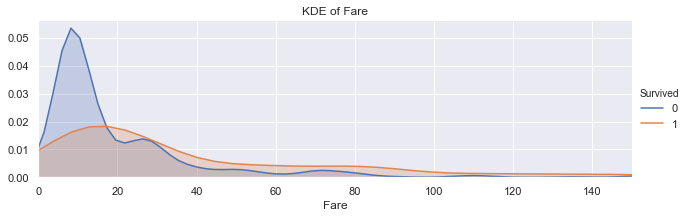

In [557]:
sns.set()
facet = sns.FacetGrid(data=data, hue='Survived', aspect = 3)
facet.map(sns.kdeplot, 'Fare', shade =True)
facet.set(xlim=(0, 150), title="KDE of Fare")
facet.add_legend()

**Conclusion**
* For Fare in (0:16), the dead probability is higher.
* Fore Fare in (16:30), the surviving probability is higher.
* Fore Fare in (30:90), the surviving probability is higher.
* Fore Fare in (90:max), we consider them sensitive observations.

In [558]:
def combine_fare(data):
    '''Combine Fare into categories 
    
    Argument:
    data : dataset
    
    Ouput : dataset with new age value
            (0:16)  : 0
            (16:30) : 1
            (30:90) : 2
            (90:max): 3'''
    
    data.loc[(data['Fare'] > 0)  & (data['Fare'] <= 16), 'Fare'] = 0
    data.loc[(data['Fare'] > 16) & (data['Fare'] <= 30), 'Fare'] = 1
    data.loc[(data['Fare'] > 30) & (data['Fare'] <= 90), 'Fare'] = 2
    data.loc[(data['Fare'] > 90)                       , 'Fare'] = 3
    
    return data

[Text(0.5, 1.0, 'Parch vs Survived')]

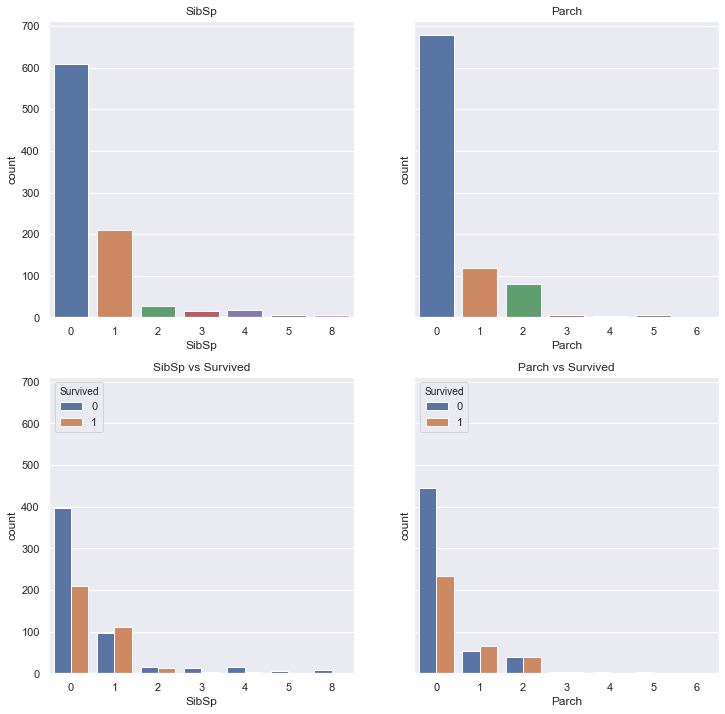

In [559]:
fig , ax = plt.subplots(2,2, figsize = (12,12), sharey=True)

sns.countplot(x='SibSp', data=data, ax=ax[0,0])
ax[0,0].set(title = 'SibSp')

sns.countplot(x='Parch', data=data, ax=ax[0,1])
ax[0,1].set(title = 'Parch')

sns.countplot(x='SibSp', data=data, hue = 'Survived', ax=ax[1,0])
ax[1,0].set(title = 'SibSp vs Survived')

sns.countplot(x='Parch', data=data, hue = 'Survived', ax=ax[1,1])
ax[1,1].set(title = 'Parch vs Survived')

**Conclusion**
* For the SibSp variable, value 0, 1 hold huge shares of SibSp. So we will combine all other value into one category.
* For the Parch variable, value 0,1,2 hold huge shares of Parch. So we will combine all other value into one category.

In [560]:
def combine_SibSp_Parch(data):
    '''Combine SibSp and Parch.'''
    
    data.loc[(data['SibSp'] > 1), 'SibSp'] = 2
    data.loc[(data['Parch'] > 3), 'Parch'] = 3
    
    return data    

In [561]:
data = combine_SibSp_Parch(data)

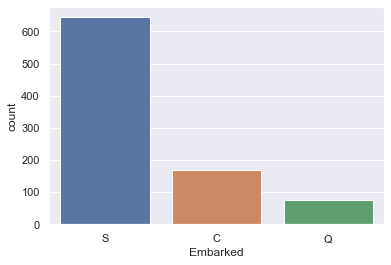

In [562]:
sns.countplot(x='Embarked', data = data)

**Conclusion** : 
* Most of passengers start from S port.
* We can replace the missing value with this value.

**For the Name, Ticket variable, there're some interesting information we can extract from these two variables.**
* Name contain title Mr/Miss/Mrs that is may more informative then sex variable.
* Ticket can group people that come together from that, we can caculate the number of people come together. We also can compute the number of people travel together by using SibSp, Parch, but there are some case, people travelling together aren't relative like below example.

In [563]:
data[data['Ticket'] == '1601']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
74,75,1,3,"Bing, Mr. Lee",male,32.0,0,0,1601,56.4958,NaN,S
169,170,0,3,"Ling, Mr. Lee",male,28.0,0,0,1601,56.4958,NaN,S
509,510,1,3,"Lang, Mr. Fang",male,26.0,0,0,1601,56.4958,NaN,S
643,644,1,3,"Foo, Mr. Choong",male,NaN,0,0,1601,56.4958,NaN,S
692,693,1,3,"Lam, Mr. Ali",male,NaN,0,0,1601,56.4958,NaN,S
826,827,0,3,"Lam, Mr. Len",male,NaN,0,0,1601,56.4958,NaN,S
838,839,1,3,"Chip, Mr. Chang",male,32.0,0,0,1601,56.4958,NaN,S


As we can see, they travel together but they aren't relative 

In [564]:
def create_title(data):
    
    ''' Function that create Title (Mr/Miss/Mrs/Master) from Name.
    
    Arguments:
    data : dataset.
    
    Output: dataset with new columns Title with value (Mr/Miss/Mrs/Master).
    
    '''

    data['Title'] = data["Name"].apply(lambda x: x[x.find(',')+2: x.find('.')])
    
    data.loc[(~data['Title'].isin(['Miss', 'Mr', 'Mrs', 'Master'])) &
             (data['Sex'] == 'male'), 'Title'
            ] = 'Mr'
    data.loc[(~data['Title'].isin(['Miss', 'Mr', 'Mrs', 'Master'])) &
             (data['Sex'] == 'female'), 'Title'
            ] = 'Miss'
    
    return data

In [565]:
data = create_title(data)

In [566]:
def create_number_accompany(data):
    ''' Function extract number of accompany from ticket (people with the same ticket travel together)
    
    Arguments:
        data : dataset
    
    Output: dataset with new columns
        Number_accompany: number of people that travel with a passenger
        is_accompany: True(travel with other passenger), False(Travel alone)
    '''
    
    unique_ticket = list(data['Ticket'].unique())
    
    data['Ticket_index'] = ""
    for i in unique_ticket:
        data.loc[data['Ticket'] == i, 'Ticket_index'] = unique_ticket.index(i)

    mapping = dict(data['Ticket_index'].value_counts())

    data['Number_accompany'] = data['Ticket_index'].map(mapping) - 1
    data['is_accompany'] = data['Number_accompany'] != 1
    
    return data

In [567]:
data = create_number_accompany(data)

[Text(0.5, 1.0, 'Parch')]

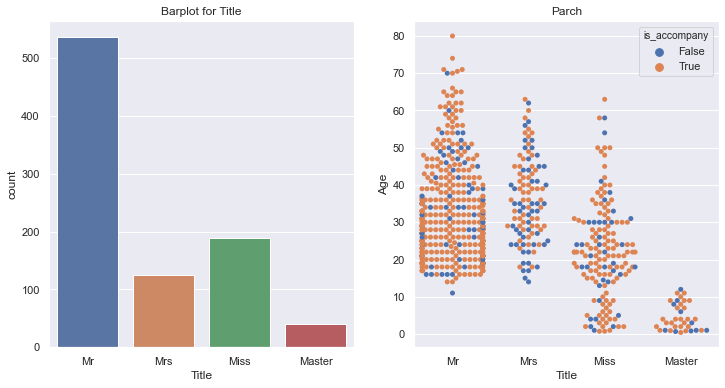

In [568]:
fig , ax = plt.subplots(1,2, figsize = (12,6), sharey=False)

sns.countplot(x='Title', data=data, ax=ax[0])
ax[0].set(title = 'Barplot for Title')

sns.swarmplot(x='Title', data=data, y='Age', hue='is_accompany',  ax=ax[1])
ax[1].set(title = 'Parch')

* There are some passenger with Age less than 14 that travel alone. They are too young for travel alone, maybe they travel with nanny, so I will set they travel with family.
* There are a group that under 14 year olds, so I will set them to a group Children.

In [569]:
def extract_children(data):
    ''' Extract Children from passenger with age lower than 14 and set them go with aldult if they travel alone
    Argument:
    data : dataset
    Output: Tilte with new value (Mr/Miss/Mrs/Children)'''
    
    data.loc[data['Age'] < 14, 'Title'] = 'Children'
    
    # In case, age missing.
    data.loc[data['Title'] == 'Master', 'Title'] = 'Children'
    
    # set children go with aldult
    
    data.loc[(data['Number_accompany'] == 1) & (data['Title'] == 'Children'), 'Number_accompany'] = 1
    data.loc[(data['Number_accompany'] == 1) & (data['Title'] == 'Children'), 'is_accompany'] = True
    
    return data

In [570]:
data = extract_children(data)
data[data['Title'] == 'Children']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Ticket_index,Number_accompany,is_accompany
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.00,2,1,349909,21.0750,NaN,S,Children,7,3,True
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.00,1,1,PP 9549,16.7000,G6,S,Children,10,1,True
16,17,0,3,"Rice, Master. Eugene",male,2.00,2,1,382652,29.1250,NaN,Q,Children,16,4,True
24,25,0,3,"Palsson, Miss. Torborg Danira",female,8.00,2,1,349909,21.0750,NaN,S,Children,7,3,True
43,44,1,2,"Laroche, Miss. Simonne Marie Anne Andree",female,3.00,1,2,SC/Paris 2123,41.5792,NaN,C,Children,42,2,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
827,828,1,2,"Mallet, Master. Andre",male,1.00,0,2,S.C./PARIS 2079,37.0042,NaN,C,Children,636,1,True
831,832,1,2,"Richards, Master. George Sibley",male,0.83,1,1,29106,18.7500,NaN,S,Children,348,2,True
850,851,0,3,"Andersson, Master. Sigvard Harald Elias",male,4.00,2,2,347082,31.2750,NaN,S,Children,13,6,True
852,853,0,3,"Boulos, Miss. Nourelain",female,9.00,1,1,2678,15.2458,NaN,C,Children,130,1,True


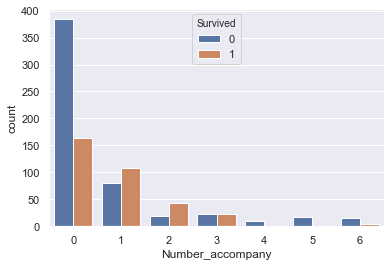

In [571]:
sns.countplot(x='Number_accompany', data=data, hue='Survived')

In [572]:
def combine_number_accompany(data):
    '''Combine value 3,4,5,6 of Number_accompany into a category
    Argument:
    data : dataset
    Output: Number_accompany with value (0,1,2,3)'''

    
    data.loc[data['Number_accompany'] > 2, 'Number_accompany'] = 3
    
    return data

We can combine value 4,5,6 of Number_accompany into a category.

In [573]:
data = combine_number_accompany(data)

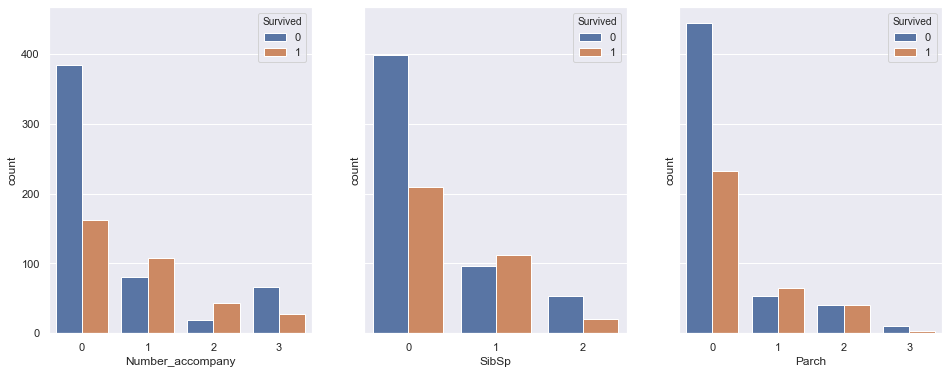

In [574]:
fig, ax = plt.subplots(1,3, figsize = (16,6), sharey = True)

sns.countplot(x='Number_accompany', data=data, hue='Survived', ax = ax[0])
sns.countplot(x='SibSp', data=data, hue='Survived', ax = ax[1])
sns.countplot(x='Parch', data=data, hue='Survived', ax = ax[2])

The probabiliy of surviving when travel alone is higher comparing with traveling with accompanies.

**FINAL CONCLUSION**
* Split Age variable into 4 interval (0:13),(13:30),(30:40),(40:80)
* Split Fare variable into (0:16),(16:30),(30:90),(90:max)
* Combine 3,4,5 into 1 category for SibSp
* Combine 4,5,6 into 1 category for Parch
* Replace Missing value in Embarked with S
* Extract title and number_accompany. Then combine value 5,6,7 of Number_accompany into one category.

# 3. Handle Missing Values

There are a lot of missing value in Cabin variable. So I will drop this variable.

Text(0.5, 1.0, 'Boxplot of Pclass')

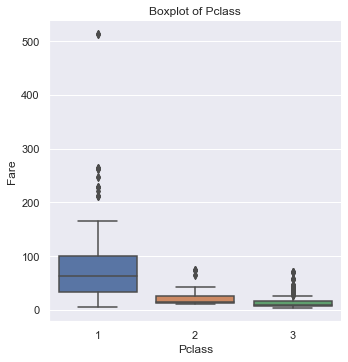

In [575]:
sns.catplot(x='Pclass', y ='Fare', data=data[data['Fare'] !=0], kind='box')
plt.title("Boxplot of Pclass")

**Conclution:** replace Fare missing value by median base on each class.

Text(0.5, 1.0, 'Boxplot of Age base on is_accompany')

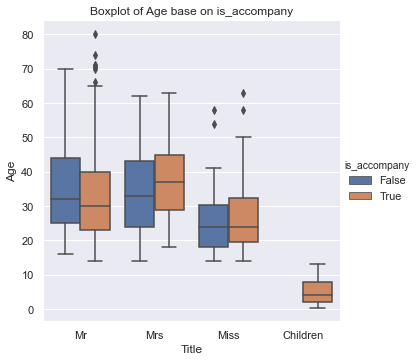

In [576]:
sns.catplot(y='Age', x='Title', data=data[~data['Age'].isnull()], hue='is_accompany', kind='box')
plt.title('Boxplot of Age base on is_accompany')

**Conclusion**
* Age's distribution of Mr, Mrs is quite similar
* Age's distribution of Miss, Master is different. So that we will replace missing value of Age's missing values by median of title group by is_accompany

**FINAL CONCLUSION**
* Replace Embarked missing value with S.
* Replace Fare missing value by median of each class.
* Replace Age missing value by median of each title group by is_accompany.
* Drop Cabin variable.

In [577]:
def missing_handle(data):
    '''Function handle missing value of Fare and Age variable.
       For Embarked variable: replace missing value with S.
       For Fare variable: replace missing value with fare median of each Pclass.
       For Age variable: replace missing value with age median of each Title.
    
    Arguments:
        data : dataset
        Output : dataset replaced missing value.'''
    
    # replace missing Embarked with S
    
    data.loc[(data['Embarked']).isnull(), 'Embarked'] = 'S'
    # replace missing fare with median
    
   
    data.loc[(data['Fare'] == 0) & 
             (data['Pclass'] == 1), 'Fare'] = np.median(data.loc[(data['Pclass']==1) & 
                                                                 (data['Fare'] != 0), 'Fare'])
    
    data.loc[(data['Fare'] == 0) & 
             (data['Pclass'] == 2), 'Fare'] = np.median(data.loc[(data['Pclass']==2) & 
                                                                 (data['Fare'] != 0), 'Fare'])
    
    data.loc[(data['Fare'] == 0) & 
             (data['Pclass'] == 3), 'Fare'] = np.median(data.loc[(data['Pclass']==3) & 
                                                                 (data['Fare'] != 0), 'Fare'])
    
    
    # replace missing age with median   
    mapping_age = {'Mr'         : np.median(data.loc[(data['Title'] == 'Mr') & 
                                                     (~data['Age'].isnull()), 'Age']),
                   'Mrs'        : np.median(data.loc[(data['Title'] == 'Mrs') & 
                                                     (~data['Age'].isnull()), 'Age']),
                   'Miss'       : np.median(data.loc[(data['Title'] == 'Miss') & 
                                                     (~data['Age'].isnull()), 'Age']),
                   'Childern':      np.median(data.loc[(data['Title'] == 'Children') & 
                                                     (~data['Age'].isnull()), 'Age'])
                  }
    data.loc[(data['Age'].isnull()) &
             (data['Title'] == 'Mr'), 'Age'] = np.median(data.loc[(data['Title'] == 'Mr') & 
                                                                  (~data['Age'].isnull()), 'Age'])
    data.loc[(data['Age'].isnull()) &
             (data['Title'] == 'Mrs'), 'Age'] = np.median(data.loc[(data['Title'] == 'Mrs') & 
                                                                  (~data['Age'].isnull()), 'Age'])
    data.loc[(data['Age'].isnull()) &
             (data['Title'] == 'Miss'), 'Age'] = np.median(data.loc[(data['Title'] == 'Miss') & 
                                                                  (~data['Age'].isnull()), 'Age'])
    data.loc[(data['Age'].isnull()) &
             (data['Title'] == 'Children'), 'Age'] = np.median(data.loc[(data['Title'] == 'Children') & 
                                                                  (~data['Age'].isnull()), 'Age'])    
    
    return data

# 4. Build Pipeline

In [578]:
class SelectFeature():
    '''Select columns using for train in the pipeline'''
    
    def __init__(self, columns=None):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X[self.columns] 

In [612]:
data = pd.read_csv('C:\\Users\\Admin\\Desktop\\titanic\\train.csv')

In [613]:
# FunctionTransformer for data pipeline
get_create_title = FunctionTransformer(create_title)
get_number_accompany = FunctionTransformer(create_number_accompany)
get_extract_children = FunctionTransformer(extract_children)
fill_missing = FunctionTransformer(missing_handle)

get_combine_age = FunctionTransformer(combine_age)
get_combine_fare = FunctionTransformer(combine_fare)
get_combine_SibSp_Parch = FunctionTransformer(combine_SibSp_Parch)

get_combine_number_accompany = FunctionTransformer(combine_number_accompany)

fill_missing = FunctionTransformer(missing_handle)

In [614]:
# Split data into train, test set.
predict_feature = data['Survived']
train_feature = data.drop('Survived', axis=1)
x_train, x_test, y_train, y_test = train_test_split(train_feature, predict_feature, test_size = 0.2, random_state=12)

In [615]:
# creat the first pipeline
step = [('create title', get_create_title),
        ('create number accompany', get_number_accompany),
        ('extract children', get_extract_children),
        ('fill missing', fill_missing),
        ('combine_age', get_combine_age),
        ('combine_fare', get_combine_fare),
        ('combine_SibSp_Parch', get_combine_SibSp_Parch),
        ('combine_number_accompany', get_combine_number_accompany),
        ('select feature', SelectFeature(['Age', 'Number_accompany', 'Title', 'Pclass', 'Fare'])),
        ('ohe', ColumnTransformer([('ohe1', OneHotEncoder(), ['Title'])])),
        ('predict', xgb.XGBClassifier(objective = 'binary:logistic', colsample_bytree = 0.3,
                                                         learning_rate = 0.1, max_depth=5, alpha = 10, n_estimators = 10))
        ]

pipeline = Pipeline(step)
pipeline.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('create title',
                 FunctionTransformer(accept_sparse=False, check_inverse=True,
                                     func=<function create_title at 0x0000021F0E00CEA0>,
                                     inv_kw_args=None, inverse_func=None,
                                     kw_args=None, validate=False)),
                ('create number accompany',
                 FunctionTransformer(accept_sparse=False, check_inverse=True,
                                     func=<function create_number_accompany at 0x0000021F0E...
                 XGBClassifier(alpha=10, base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.3, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=5,
                               min_child_weight=1, missing=None,
                               n_estimators=10, n_jobs=1, nthre

In [616]:
y_pred = pipeline.predict(x_test)

In [617]:
def summarize_classification(y_test, y_pred):
    '''This function return accuracy, precision, recall of a model'''
    acc = accuracy_score(y_test, y_pred, normalize=True)
    num_acc = accuracy_score(y_test, y_pred, normalize=False)
    
    prec = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    return {'accuracy': acc,
            'precision': prec,
            'recall': recall,
            'accuracy_count': num_acc}

In [618]:
test_scores = summarize_classification(y_test, y_pred)
test_scores

{'accuracy': 0.7541899441340782,
 'precision': 0.7108433734939759,
 'recall': 0.7468354430379747,
 'accuracy_count': 135}

In [619]:
unseen_data = pd.read_csv('C:\\Users\\Admin\\Desktop\\titanic\\test.csv')

In [620]:
submission = pd.read_csv('C:\\Users\\Admin\\Desktop\\titanic\\gender_submission.csv')

In [621]:
submission['Survived'] = pipeline.predict(unseen_data)
submission.set_index('PassengerId')
submission.to_csv('C:\\Users\\Admin\\Desktop\\titanic\\gender_submission1.csv', index=False)